In [ ]:
from importlib import reload
import sys
from imp import reload
import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DataSetFull - Worked in attention (1).csv to DataSetFull - Worked in attention (1).csv


In [ ]:
import io
messages = pd.read_csv(io.BytesIO(uploaded['DataSetFull - Worked in attention (1).csv']),sep =',', names=["status", "comment"])
# Split data into train and test
messages.comment.apply(lambda x: len(x.split(" "))).mean()


12.434120778572616

In [ ]:
# # Convert to a DataFrame and render.
# pd.DataFrame.from_records(rows)
messages.groupby('status').describe()

comment                          
         count unique           top freq
status                                  
0         7147   6850  জি জি এই তো     4
1         4875   4511       বাইনচোদ   10

Data describe

In [ ]:
# for i in messages:
#   print(i)

status
comment


In [ ]:
list2=[]
for i in messages.comment:
  temp=i.split();
  for j in temp:
    list2.append(j)

  

In [ ]:
len(list2)

126123

In [ ]:
def most_frequent(List):
    return max(set(List), key = List.count)
print(most_frequent(list2))

না


In [ ]:
train_msg, test_msg, train_labels, test_labels = train_test_split(messages['comment'], messages['status'], test_size=0.2, random_state=2)

In [ ]:
# # Defining pre-processing hyperparameters
# max_len = 50 
# trunc_type = "post" 
# padding_type = "post" 
# oov_tok = "<OOV>" 
# vocab_size = 500
# tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
# tokenizer.fit_on_texts(train_msg)
# # Get the word_index 
# word_index = tokenizer.word_index
# word_index
# # check how many words 
# tot_words = len(word_index)
# print('There are %s unique tokens in training data. ' % tot_words)

# # Sequencing and padding on training and testing 
# training_sequences = tokenizer.texts_to_sequences(train_msg)
# training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
# testing_sequences = tokenizer.texts_to_sequences(test_msg)
# testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
# padding = padding_type, truncating = trunc_type)



MAX_FEATURES = 6000
EMBED_SIZE = 128
RNN_CELL_SIZE = 32
MAX_LEN = 15   # Since our mean length is 12.43

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_msg)
list_tokenized_train = tokenizer.texts_to_sequences(train_msg)
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = train_labels

list_tokenized_test = tokenizer.texts_to_sequences(test_msg)
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)
Y_test = test_labels


In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

# Removal of the globalMaxPool1D could be trouble
#globmax = GlobalMaxPool1D()(context_vector)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 128)      768000      ['input_1[0][0]']                
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 15, 64)       41216       ['embedding[0][0]']              
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 15, 64),     24832       ['bi_lstm_0[0][0]']              
                                 (None, 32),                                                  

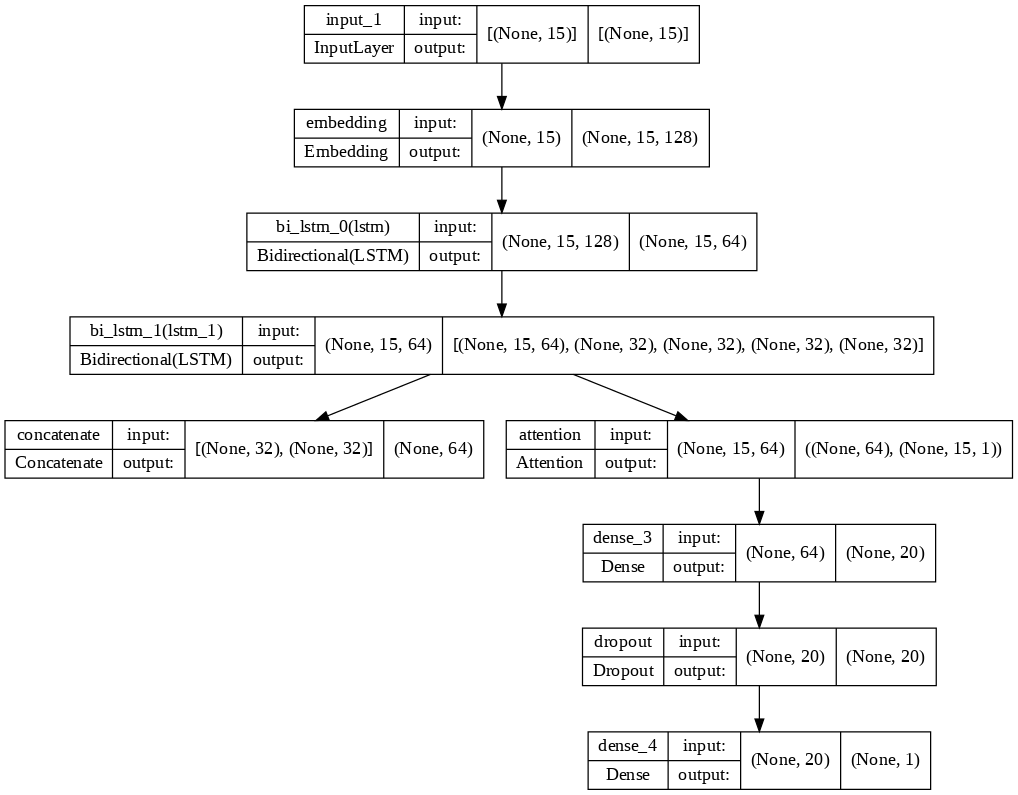

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)


In [ ]:
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/5
77/77 [==============================] - 18s 101ms/step - loss: 0.4251 - tp: 1654.0000 - fp: 189.0000 - tn: 4386.0000 - fn: 1464.0000 - accuracy: 0.7851 - precision: 0.8974 - recall: 0.5305 - auc: 0.8750 - val_loss: 0.1959 - val_tp: 710.0000 - val_fp: 92.0000 - val_tn: 1075.0000 - val_fn: 47.0000 - val_accuracy: 0.9278 - val_precision: 0.8853 - val_recall: 0.9379 - val_auc: 0.9771
Epoch 2/5
77/77 [==============================] - 5s 65ms/step - loss: 0.1149 - tp: 2916.0000 - fp: 123.0000 - tn: 4452.0000 - fn: 202.0000 - accuracy: 0.9578 - precision: 0.9595 - recall: 0.9352 - auc: 0.9904 - val_loss: 0.2025 - val_tp: 652.0000 - val_fp: 24.0000 - val_tn: 1143.0000 - val_fn: 105.0000 - val_accuracy: 0.9330 - val_precision: 0.9645 - val_recall: 0.8613 - val_auc: 0.9794
Epoch 3/5
77/77 [==============================] - 5s 62ms/step - loss: 0.0634 - tp: 3019.0000 - fp: 65.0000 - tn: 4510.0000 - fn: 99.0000 - accuracy: 0.9787 - precision: 0.9789 - recall: 0.9682 - auc: 0.9958 - val

In [ ]:
## Making predictions on our model
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1405
           1       0.94      0.87      0.90      1000

    accuracy                           0.92      2405
   macro avg       0.93      0.92      0.92      2405
weighted avg       0.92      0.92      0.92      2405



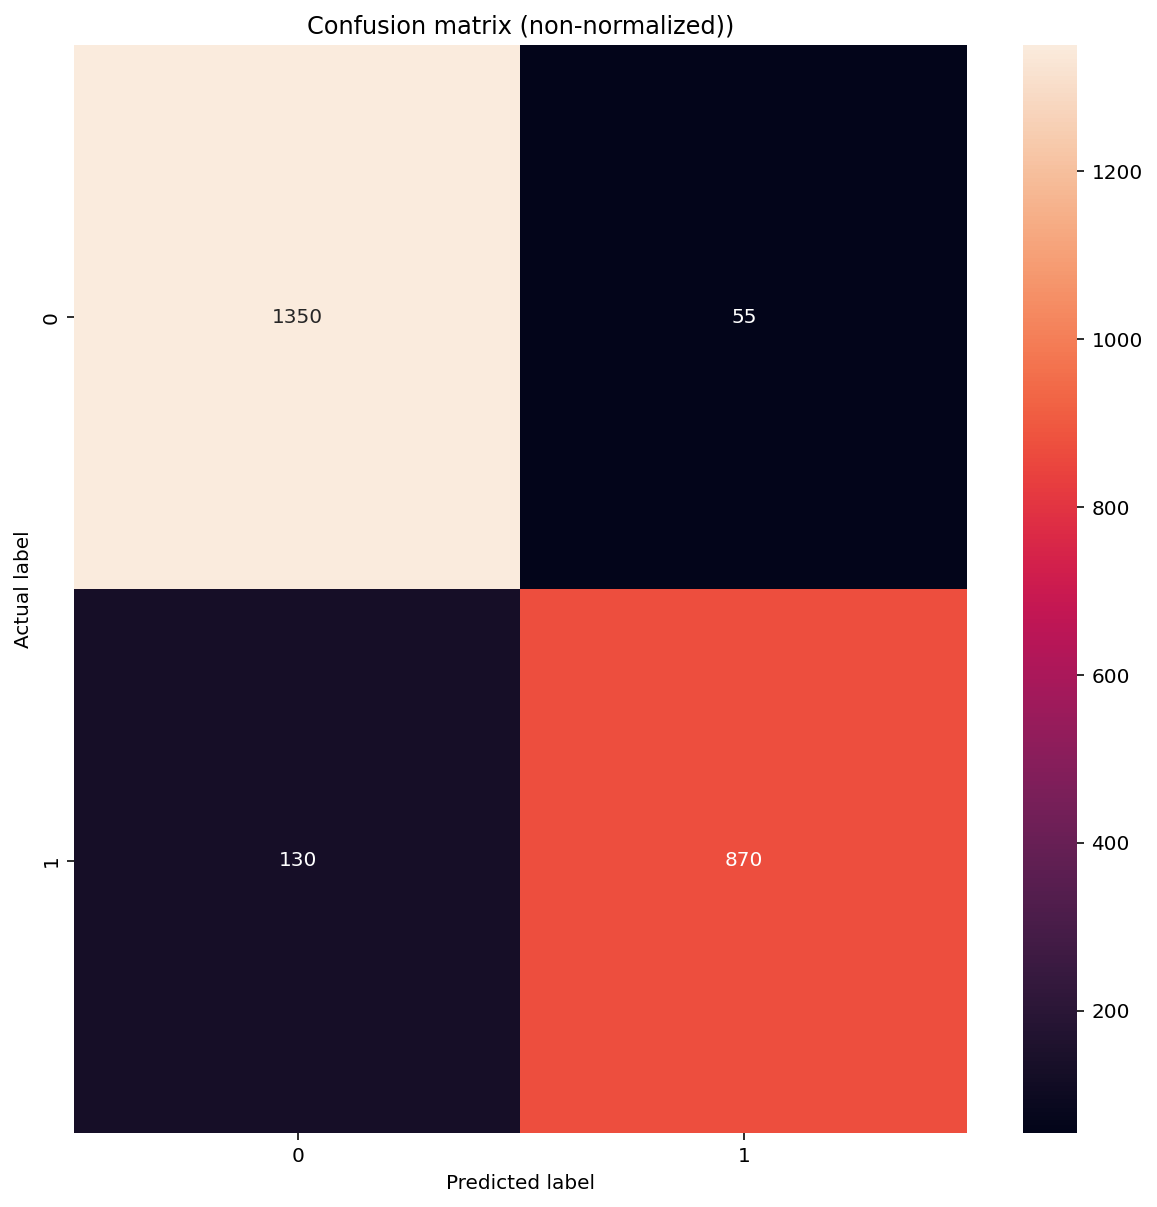

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report = classification_report(Y_test, y_pred)
print(report)


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(Y_test, y_pred)